# Modeling a Pincell
In this lecture, we'll demonstrate the basic features of the Python API for constructing input files and running OpenMC. In it, we will show how to create a basic reflective pincell model that is equivalent to modeling an infinite array of fuel pins in a pressurized water reactor. We highly recommend having a copy of the [Python API reference documentation](https://docs.openmc.org/en/stable/pythonapi/index.html) open in another browser tab that you can refer to.

<img src="pincell.png" alt="drawing" width="250"/>

For this example, we'll create a simple pincell that is composed of:
- UO<sub>2</sub> with 3.5 weight% enriched in U-235 at 11 g/cm<sup>3</sup>
- zirconium clad at 6.5 g/cm<sup>3</sup>
- H<sub>2</sub>O moderator at 1.0 g/cm<sup>3</sup>

The dimensions of our fuel pin will be as follows:
- Fuel outer radius = 0.46955 cm
- Clad inner radius = 0.47910 cm
- Clad outer radius = 0.54640 cm
- Fuel pin pitch = 1.44270 cm
- Pin height = 300.0 cm

In [4]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

## Basics of Jupyter Notebook

You are working within a Jupyter notebook. Some common commands which will be useful:
- To execute a cell: `Shift+Enter`
- To insert a cell above or below: `Esc+a`, `Esc+b`

## Naming Conventions

Before we start working with OpenMC's Python API, it's helpful to understand the naming convention of objects so that you can conceptualize what is a function, what is a class, etc. OpenMC's Python interface follows the same naming convention that is adopted by many/most Python projects:

- Module names are `lowercase`
- Classes are `CamelCase`
- Functions and class attributes/variables are `lowercase_with_underscores`

To give a few specific examples:

- `openmc.deplete` is the depletion _module_
- `openmc.run` is a _function_
- `openmc.Material` is a _class_
- `openmc.StatePoint` is a _class_

## Setting Attributes

When building OpenMC models, we will work with many different classes. Each class typically has _attributes_, a variable belonging to the class. When creating a class, you can often set those attributes directly when you instantiate the object, like this:

In [5]:
my_cell = openmc.Cell(name="april")

In [6]:
my_cell.name = "harun"

Or, you can assign values to attributes after you have already created the object. For example, the following is equivalent to the above:

You can generally also mix-and-match, setting some attributes when you instantiate the object, and others at a later point.

In [7]:
my_cell = openmc.Cell(name="i love 455")
my_cell.temperature = 500


## How to Get Help/Learn More

When building OpenMC models, we recommend having a copy of the Python API documentation (linked earlier) open. You can also query information about classes and methods directly from Jupyter. For example, we can use `help` to get documentation on all of the valid attributes for functions and classes.

In [8]:
help(openmc.Cell)

Help on class Cell in module openmc.cell:

class Cell(openmc.mixin.IDManagerMixin)
 |  Cell(cell_id=None, name='', fill=None, region=None)
 |  
 |  A region of space defined as the intersection of half-space created by
 |  quadric surfaces.
 |  
 |  Parameters
 |  ----------
 |  cell_id : int, optional
 |      Unique identifier for the cell. If not specified, an identifier will
 |      automatically be assigned.
 |  name : str, optional
 |      Name of the cell. If not specified, the name is the empty string.
 |  fill : openmc.Material or openmc.UniverseBase or openmc.Lattice or None or iterable of openmc.Material, optional
 |      Indicates what the region of space is filled with
 |  region : openmc.Region, optional
 |      Region of space that is assigned to the cell.
 |  
 |  Attributes
 |  ----------
 |  id : int
 |      Unique identifier for the cell
 |  name : str
 |      Name of the cell
 |  fill : openmc.Material or openmc.UniverseBase or openmc.Lattice or None or iterable of o

Attributes which have a default value will appear as `<attribute>=<the default value>` in the class/function definition. For example, in the above we see that the default name for a cell is the empty string, `''`.

For classes, all of the member functions you can access will then be defined further down, with their associated documentation. To see documentation for just one specific function, you can use syntax like:

In [9]:
print(my_cell)

Cell
	ID             =	2
	Name           =	i love 455
	Fill           =	None
	Region         =	None
	Rotation       =	None
	Translation    =	None
	Volume         =	None



In order to quickly see all of the member functions on a class, press `Tab` to perform tab-completion to view a drop-down list on all the options available to you. You can then do `Shift+Tab` to see the documentation for each function inline.

In [ ]:
#my_cell.

## OpenMC Model

The OpenMC `Model` class houses all of the pieces of a Monte Carlo simulation. We will assemble our pincell by progressively adding to a model, and then run that model.

In [10]:
model = openmc.Model()

### The `cross_sections.xml` file

The `cross_sections.xml` tells OpenMC where it can find nuclide cross sections and $S(\alpha,\beta)$ tables. Let's have a look at what's inside this file:

In [11]:
!cat $OPENMC_CROSS_SECTIONS | head -n 10

<?xml version='1.0' encoding='utf-8'?>
<cross_sections>
  <library materials="H1" path="neutron/H1.h5" type="neutron" />
  <library materials="H2" path="neutron/H2.h5" type="neutron" />
  <library materials="H3" path="neutron/H3.h5" type="neutron" />
  <library materials="He3" path="neutron/He3.h5" type="neutron" />
  <library materials="He4" path="neutron/He4.h5" type="neutron" />
  <library materials="Li6" path="neutron/Li6.h5" type="neutron" />
  <library materials="Li7" path="neutron/Li7.h5" type="neutron" />
  <library materials="Be7" path="neutron/Be7.h5" type="neutron" />


## Defining Materials

Materials in OpenMC are defined as a set of nuclides with specified atom/weight fractions. To begin, we will create a material by making an instance of the `Material` class.

In [12]:
zirconium = openmc.Material()
zirconium.name = "zirconium"

The `Material` class has a method `add_element()` whose first argument is the name of the nuclide and second argument is the atom or weight fraction. We see that by default it assumes we want an atom fraction.

In [13]:
zirconium.add_element('Zr', 1.0)

In [14]:
print(zirconium)

Material
	ID             =	1
	Name           =	zirconium
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.5145       [ao]
	Zr91           =	0.1122       [ao]
	Zr92           =	0.1715       [ao]
	Zr94           =	0.1738       [ao]
	Zr96           =	0.028        [ao]



In [15]:
zirconium.set_density('g/cm3', 6.5)

We can see that OpenMC automatically inserted the natural abundances of the zirconium isotopes for us! How convenient! 

Let's now build our fuel material. For sake of illustration, let's suppose that we had O-16, but not natural oxygen in our fuel. Also note that OpenMC has a convenient feature to set the nuclide concentrations for weight percent enrichments in U-235.

In [16]:
uo2 = openmc.Material(name="fuel")
uo2.add_nuclide('O16', 2.0)
uo2.add_element('U', 1.0, enrichment=3.5)

In [17]:
print(uo2)

Material
	ID             =	2
	Name           =	fuel
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	O16            =	2.0          [ao]
	U234           =	0.0003166930253944235 [ao]
	U235           =	0.03543164439454172 [ao]
	U238           =	0.964089368630351 [ao]
	U236           =	0.00016229394971280895 [ao]



In [18]:
uo2.set_density('g/cm3', 10.0)

With UO2 finished, let's now create materials for the coolant.

In [20]:
water = openmc.Material(name="moderator")
water.add_element('H', 2)
water.add_element('O', 1)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

An astute observer might now point out that this water material we just created will only use free-atom cross sections. We need to tell it to use an $S(\alpha,\beta)$ table so that the bound atom cross section is used at thermal energies. To do this, there's an `add_s_alpha_beta()` method.

We are done with our materials -- now we just need to register them in our model.

In [21]:
model.materials = openmc.Materials([uo2, zirconium, water])

## Defining Geometry

We now need to define the geometry. One way to do so is to use constructive solid geometry (CSG), also known as combinatorial geometry. The object that allows us to assign a material to a region of space is called a `Cell`. There are four stages in building a cell:

#### Surfaces
In order to define a region that we can assign to a cell, we must first define surfaces which bound the region. A *surface* is a locus of zeros of a function of Cartesian coordinates $x$, $y$, and $z$, e.g.

- A plane perpendicular to the x axis: $x - x_0 = 0$
- A cylinder parallel to the z axis: $(x - x_0)^2 + (y - y_0)^2 - R^2 = 0$
- A sphere: $(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 - R^2 = 0$

The full [list of available surfaces](https://docs.openmc.org/en/stable/pythonapi/base.html#building-geometry) is as follows.

Planes:

- `openmc.Plane` — An arbitrary plane of the form $Ax + By + Cz = D$
- `openmc.XPlane` — A plane perpendicular to the x axis of the form $x - x_0 = 0$
- `openmc.YPlane` — A plane perpendicular to the y axis of the form $y - y_0 = 0$
- `openmc.ZPlane` — A plane perpendicular to the z axis of the form $z - z_0 = 0$

Quadrics:

- `openmc.XCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(y - y_0)^2 + (z - z_0)^2 = r^2$
- `openmc.YCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(x - x_0)^2 + (z - z_0)^2 = r^2$
- `openmc.ZCylinder` — An infinite cylinder whose length is parallel to the x-axis of the form $(x - x_0)^2 + (y - y_0)^2 = r^2$
- `openmc.Sphere` — A sphere of the form $(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 = r^2$
- `openmc.XCone` — A cone parallel to the x-axis of the form $(y - y_0)^2 + (z - z_0)^2 = r^2 (x - x_0)^2$
- `openmc.YCone` — A cone parallel to the y-axis of the form $(x - x_0)^2 + (z - z_0)^2 = r^2 (y - y_0)^2$
- `openmc.ZCone` — A cone parallel to the z-axis of the form $(x - x_0)^2 + (y - y_0)^2 = r^2 (z - z_0)^2$
- `openmc.Quadric` — A generic quadric surface

Torii:

- `openmc.XTorus` — A torus of the form $(x - x_0)^2/B^2 + (\sqrt{(y - y_0)^2 + (z - z_0)^2} - A)^2/C^2 - 1 = 0$
- `openmc.YTorus` — A torus of the form $(y - y_0)^2/B^2 + (\sqrt{(x - x_0)^2 + (z - z_0)^2} - A)^2/C^2 - 1 = 0$
- `openmc.ZTorus` — A torus of the form $(z - z_0)^2/B^2 + (\sqrt{(x - x_0)^2 + (y - y_0)^2} - A)^2/C^2 - 1 = 0$

#### Half-Spaces

<img src="csg_half.png" alt="drawing" width="600"/>

A surface *half-space* is the region whose points satisfy a positive or negative inequality of the surface equation. For example, for a sphere of radius one centered at the origin, the surface equation is $f(x,y,z) = x^2 + y^2 + z^2 - 1 = 0$. Thus, we say that the negative half-space of the sphere is defined as the collection of points satisfying $f(x,y,z) < 0$, which one can reason is the inside of the sphere. Conversely, the positive half-space of the sphere would correspond to all points outside of the sphere.

#### Regions
A region is then a combination of (or just one) half-spaces.

<img src="csg.png" alt="drawing" width="400"/>

#### Fills
Finally, a cell is complete once we have defined what is _filling_ the cell, which may be one of:

- material
- nothing (`None`), or vacuum/void
- universe
- lattice

In [22]:
sphere = openmc.Sphere(x0=0, y0=0, z0=0, r=1)

To get the negative or positive half-space, we simply need to apply the `-` or `+` unary operators, respectively.

In [23]:
inside_sphere = -sphere
outside_sphere = +sphere

Now let's see if `inside_sphere` actually contains points inside the sphere:

In [24]:
print((0, 0, 0) in inside_sphere)

True


In [26]:
print((100, 0, 0) in outside_sphere)

True


Everything works as expected! Now that we understand how to create half-spaces, we can create more complex volumes by combining half-spaces using Boolean operators: `&` (intersection), `|` (union), and `~` (complement):

- `&`: logical AND
- `|`: logical OR
- `~`: logical NOT

For example, let's say we want to define a region that is the top part of the sphere (all points inside the sphere that have $z > 0$.

In [27]:
z_plane = openmc.ZPlane(0)

In [28]:
northern_hemi = -sphere & +z_plane

In [29]:
cell = openmc.Cell()
cell.region = northern_hemi
cell.fill = water

### Universes and in-line plotting

A collection of cells is known as a universe and can be used as a repeatable unit when creating a model. Although we don't need it yet, the benefit of creating a universe is that we can visualize our geometry while we're creating it.

In [30]:
universe = openmc.Universe()
universe.add_cell(cell)

The `Universe` object has a `plot` method that will display our the universe as current constructed:

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

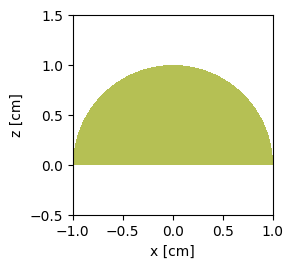

In [31]:
universe.plot(width=(2.0, 2.0), basis='xz')

### Boundary Conditions

To specify boundary conditions, you simply need to set the `Surface.boundary_type` to one of:

- `transmission` (default)
- `vacuum`
- `reflective`
- `periodic` (either rotational or translational)
- `white` (isotropic angular flux)

<img src="mc_bcs.png" alt="drawing" width="600"/>

In [32]:
sphere.boundary_type = 'vacuum'
z_plane.boundary_type = 'vacuum'

### Pin cell geometry

We now have enough knowledge to create our pin-cell. We need three surfaces to define the fuel and clad:

1. The outer surface of the fuel -- a cylinder parallel to the z axis
2. The inner surface of the clad -- same as above
3. The outer surface of the clad -- same as above

These three surfaces will all be instances of `openmc.ZCylinder`, each with a different radius according to the specification.

In [33]:
fuel_outer_radius = openmc.ZCylinder(r=0.46955)
clad_inner_radius = openmc.ZCylinder(r=0.47910)
clad_outer_radius = openmc.ZCylinder(r=0.54640)

With the surfaces created, we can now take advantage of the built-in operators on surfaces to create regions for the fuel, the gap, and the clad:

In [34]:
fuel_region = -fuel_outer_radius
clad_region = -clad_outer_radius & +clad_inner_radius
gap_region = -clad_inner_radius & +fuel_outer_radius

We will also create two z-planes in order to bound the geometry in the axial direction.

In [36]:
top = openmc.ZPlane(z0=150, boundary_type='vacuum')
bot = openmc.ZPlane(z0=-150, boundary_type='vacuum')
layer = +bot & -top

Now we can create corresponding cells that assign materials to these regions.

In [37]:
fuel = openmc.Cell()
fuel.region = fuel_region & layer
fuel.fill = uo2

gap = openmc.Cell()
gap.region = gap_region & layer
gap.fill = None

clad = openmc.Cell()
clad.fill = zirconium
clad.region = clad_region & layer

Finally, we need to handle the coolant outside of our fuel pin. To do this, we create x- and y-planes that bound the geometry.

In [38]:
pitch = 1.44270
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')

front = openmc.YPlane(-pitch/2, boundary_type='reflective')
back = openmc.YPlane(pitch/2, boundary_type='reflective')

The water region is going to be everything outside of the clad outer radius and within the box formed as the intersection of four half-spaces.

In [39]:
moderator = openmc.Cell()
moderator.fill = water
moderator.region = +clad_outer_radius & layer & +left & -right & +front & -back

The final step is to assign the cells we created to a universe and tell OpenMC that this universe is the "root" universe in our geometry.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

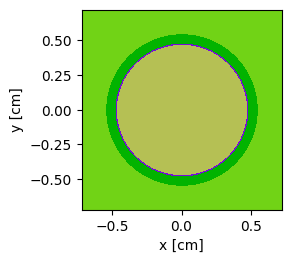

In [40]:
universe = openmc.Universe(cells=(fuel, gap, clad, moderator))
universe.plot(width=(pitch, pitch), basis='xy')

In [43]:
model.geometry = openmc.Geometry(universe)

## Starting source and settings

The Python API has a module `openmc.stats` with various univariate and multivariate probability distributions. We can use these distributions to create a starting source using the `openmc.Source` object. One can independently specify the spatial distribution (`space`), the angular distribution (`angle`), the energy distribution (`energy`), and the time distribution (`time`). For this example, we'll only specify the spatial distribution as uniform over the pincell, but only in the fissionable materials.

In [ ]:
# Create a uniform source
model.settings.source = openmc.IndependentSource(space=openmc.stats.Box(
    [-pitch/2, -pitch/2, 0], [pitch/2, pitch/2, 300], only_fissionable=True))

In [41]:
model.settings.batches = 400
model.settings.inactive = 200
model.settings.particles = 1000

## Running OpenMC

Running OpenMC from Python can be done using the `model.run()` function.

In [44]:
statepoint = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      199/1    1.40034
      200/1    1.36669
      201/1    1.38335
      202/1    1.31872    1.35104 +/- 0.03232
      203/1    1.45014    1.38407 +/- 0.03794
      204/1    1.41234    1.39114 +/- 0.02774
      205/1    1.46062    1.40503 +/- 0.02559
      206/1    1.47107    1.41604 +/- 0.02362
      207/1    1.46751    1.42339 +/- 0.02127
      208/1    1.47372    1.42968 +/- 0.01947
      209/1    1.36537    1.42254 +/- 0.01860
      210/1    1.42189    1.42247 +/- 0.01663
      211/1    1.40304    1.42071 +/- 0.01515
      212/1    1.43373    1.42179 +/- 0.01387
      213/1    1.34452    1.41585 +/- 0.01408
      214/1    1.51964    1.42326 +/- 0.01499
      215/1    1.45957    1.42568 +/- 0.01417
      216/1    1.41146    1.42479 +/- 0.01328
      217/1    1.39128    1.42282 +/- 0.01263
      218/1    1.50257    1.42725 +/- 0.01271
      219/1    1.32007    1.42161 +/- 0.01328
      220/1    1.49186    1.42512 +/- 0.01308
      221/1    1.51964    1.42962 +/- 0.01323
      222/1

      385/1    1.43826    1.42709 +/- 0.00392
      386/1    1.37834    1.42683 +/- 0.00391
      387/1    1.38623    1.42661 +/- 0.00389
      388/1    1.35907    1.42625 +/- 0.00389
      389/1    1.32163    1.42570 +/- 0.00391
      390/1    1.50151    1.42610 +/- 0.00391
      391/1    1.41201    1.42603 +/- 0.00389
      392/1    1.37342    1.42575 +/- 0.00388
      393/1    1.38177    1.42552 +/- 0.00386
      394/1    1.47069    1.42576 +/- 0.00385
      395/1    1.46172    1.42594 +/- 0.00384
      396/1    1.48356    1.42624 +/- 0.00383
      397/1    1.40025    1.42610 +/- 0.00381
      398/1    1.46912    1.42632 +/- 0.00380
      399/1    1.45582    1.42647 +/- 0.00378
      400/1    1.37629    1.42622 +/- 0.00377
 Creating state point statepoint.400.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.4768e+00 seconds
   Reading cross sections          = 2.3685e+00 seconds
 Total time in simulation     

In [45]:
with openmc.StatePoint(statepoint) as sp:
  k = sp.keff.nominal_value
  k_std_dev = sp.keff.std_dev

In [46]:
print(k)

1.4255346660382995


### Running in a loop

For several questions on CP3, you're asked to repeatedly run OpenMC using different setting

In [47]:
particles = [500, 1000, 2000]
k_values = []
err_values = []
for p in particles:
    # fill in this loop
    model.settings.particles = p
    statepoint = model.run()
    
    with openmc.StatePoint(statepoint) as sp:
        k_values.append(sp.keff.nominal_value)
        err_values.append(sp.keff.std_dev)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      204/1    1.48146    1.40310 +/- 0.05293
      205/1    1.40870    1.40422 +/- 0.04102
      206/1    1.41752    1.40644 +/- 0.03356
      207/1    1.36274    1.40020 +/- 0.02904
      208/1    1.35155    1.39412 +/- 0.02588
      209/1    1.41279    1.39619 +/- 0.02292
      210/1    1.36320    1.39289 +/- 0.02076
      211/1    1.33088    1.38725 +/- 0.01961
      212/1    1.30642    1.38052 +/- 0.01912
      213/1    1.40616    1.38249 +/- 0.01770
      214/1    1.42138    1.38527 +/- 0.01662
      215/1    1.38266    1.38509 +/- 0.01548
      216/1    1.51892    1.39346 +/- 0.01672
      217/1    1.52913    1.40144 +/- 0.01762
      218/1    1.48124    1.40587 +/- 0.01719
      219/1    1.52195    1.41198 +/- 0.01737
      220/1    1.47853    1.41531 +/- 0.01681
      221/1    1.33185    1.41134 +/- 0.01648
      222/1    1.32759    1.40753 +/- 0.01617
      223/1    1.47188    1.41033 +/- 0.01570
      224/1    1.44445    1.41175 +/- 0.01510
      225/1    1.43187    1.41255 

      385/1    1.48304    1.42430 +/- 0.00553
      386/1    1.45450    1.42447 +/- 0.00550
      387/1    1.55158    1.42515 +/- 0.00551
      388/1    1.39006    1.42496 +/- 0.00548
      389/1    1.34663    1.42455 +/- 0.00547
      390/1    1.35808    1.42420 +/- 0.00545
      391/1    1.46663    1.42442 +/- 0.00543
      392/1    1.32078    1.42388 +/- 0.00543
      393/1    1.40286    1.42377 +/- 0.00540
      394/1    1.50735    1.42420 +/- 0.00539
      395/1    1.31165    1.42362 +/- 0.00539
      396/1    1.55132    1.42427 +/- 0.00541
      397/1    1.50641    1.42469 +/- 0.00539
      398/1    1.54390    1.42529 +/- 0.00540
      399/1    1.41622    1.42525 +/- 0.00537
      400/1    1.34300    1.42484 +/- 0.00536
 Creating state point statepoint.400.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.8158e+00 seconds
   Reading cross sections          = 1.7357e+00 seconds
 Total time in simulation     

      116/1    1.47394
      117/1    1.37791
      118/1    1.38100
      119/1    1.50955
      120/1    1.39970
      121/1    1.37176
      122/1    1.39539
      123/1    1.46991
      124/1    1.47497
      125/1    1.43090
      126/1    1.41560
      127/1    1.43165
      128/1    1.47648
      129/1    1.47362
      130/1    1.46726
      131/1    1.40659
      132/1    1.44314
      133/1    1.41369
      134/1    1.34107
      135/1    1.41433
      136/1    1.51504
      137/1    1.35526
      138/1    1.40294
      139/1    1.33476
      140/1    1.40188
      141/1    1.44699
      142/1    1.38943
      143/1    1.38900
      144/1    1.52878
      145/1    1.46035
      146/1    1.35942
      147/1    1.50441
      148/1    1.43061
      149/1    1.47359
      150/1    1.46238
      151/1    1.45230
      152/1    1.41272
      153/1    1.41796
      154/1    1.33856
      155/1    1.43006
      156/1    1.43568
      157/1    1.49755
      158/1    1.45369
      159/1

      340/1    1.48071    1.42447 +/- 0.00460
      341/1    1.44189    1.42459 +/- 0.00457
      342/1    1.51035    1.42520 +/- 0.00458
      343/1    1.44611    1.42534 +/- 0.00455
      344/1    1.39142    1.42511 +/- 0.00452
      345/1    1.44882    1.42527 +/- 0.00449
      346/1    1.38157    1.42497 +/- 0.00447
      347/1    1.48391    1.42537 +/- 0.00446
      348/1    1.41243    1.42528 +/- 0.00443
      349/1    1.45111    1.42546 +/- 0.00441
      350/1    1.45511    1.42565 +/- 0.00438
      351/1    1.35688    1.42520 +/- 0.00438
      352/1    1.36248    1.42479 +/- 0.00437
      353/1    1.49616    1.42525 +/- 0.00436
      354/1    1.43517    1.42532 +/- 0.00433
      355/1    1.46443    1.42557 +/- 0.00431
      356/1    1.49325    1.42600 +/- 0.00431
      357/1    1.46730    1.42627 +/- 0.00429
      358/1    1.44138    1.42636 +/- 0.00426
      359/1    1.36757    1.42599 +/- 0.00425
      360/1    1.38832    1.42576 +/- 0.00423
      361/1    1.45609    1.42595 

       25/1    1.40797
       26/1    1.40138
       27/1    1.47510
       28/1    1.50369
       29/1    1.49480
       30/1    1.33785
       31/1    1.45844
       32/1    1.39601
       33/1    1.45702
       34/1    1.40882
       35/1    1.47445
       36/1    1.40931
       37/1    1.44742
       38/1    1.37378
       39/1    1.42753
       40/1    1.47499
       41/1    1.48766
       42/1    1.39225
       43/1    1.52532
       44/1    1.43307
       45/1    1.47850
       46/1    1.45675
       47/1    1.46690
       48/1    1.42320
       49/1    1.35715
       50/1    1.42379
       51/1    1.40783
       52/1    1.42481
       53/1    1.40232
       54/1    1.48463
       55/1    1.35845
       56/1    1.44380
       57/1    1.42760
       58/1    1.42887
       59/1    1.43195
       60/1    1.49076
       61/1    1.45182
       62/1    1.47788
       63/1    1.41114
       64/1    1.30504
       65/1    1.44660
       66/1    1.41001
       67/1    1.42730
       68/1

      292/1    1.48530    1.42327 +/- 0.00435
      293/1    1.38625    1.42287 +/- 0.00432
      294/1    1.41897    1.42283 +/- 0.00428
      295/1    1.41300    1.42272 +/- 0.00423
      296/1    1.37683    1.42224 +/- 0.00422
      297/1    1.43618    1.42239 +/- 0.00418
      298/1    1.42720    1.42244 +/- 0.00413
      299/1    1.47818    1.42300 +/- 0.00413
      300/1    1.42605    1.42303 +/- 0.00409
      301/1    1.41766    1.42298 +/- 0.00405
      302/1    1.43981    1.42314 +/- 0.00401
      303/1    1.45923    1.42349 +/- 0.00399
      304/1    1.42181    1.42348 +/- 0.00395
      305/1    1.38516    1.42311 +/- 0.00393
      306/1    1.48208    1.42367 +/- 0.00393
      307/1    1.43632    1.42379 +/- 0.00390
      308/1    1.41740    1.42373 +/- 0.00386
      309/1    1.41542    1.42365 +/- 0.00382
      310/1    1.39920    1.42343 +/- 0.00380
      311/1    1.47582    1.42390 +/- 0.00379
      312/1    1.39670    1.42366 +/- 0.00377
      313/1    1.35424    1.42304 

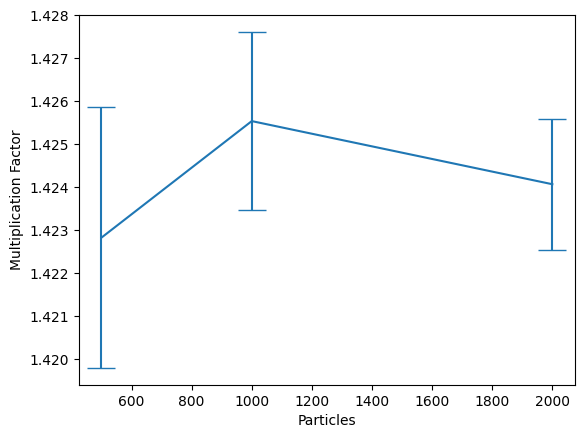

In [49]:
plt.errorbar(particles, k_values, yerr=err_values, capsize=10)
plt.xlabel('Particles')
plt.ylabel('Multiplication Factor')
plt.show()

## Tallies

In this section, we'll be looking at how to extract custom information from an OpenMC simulation in what is known as a "tally." A tally accumulates statistical information during the simulation about particles when they eneter regions of phase space specified on the tally. The limits of these regions are set by "filters" applied to the tally. Scores and nuclides can also be applied to tallies to indicate what type of information is kept about the particle (e.g. reaction types, flux, heat, etc.).

Any tally in OpenMC can be described with the following form:

$$ 
 X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int
    dE}_{\text{filters}} \underbrace{f(\mathbf{r}, \mathbf{\Omega},
    E)}_{\text{scores}} \underbrace{\psi (\mathbf{r}, \mathbf{\Omega}, E)}_{\text{angular flux}}
$$

where filters set the limits of the integrals and the scoring function is convolved with particle information (e.g. reaction type, current material, etc.). For example, if you wanted to calculate the fission reaction rate caused by fast neutrons in cell 3, your tally becomes

$$ 
 X = \int_\text{cell 3} d\mathbf{r} \int_{4\pi} d\mathbf{\Omega} \int_{1 MeV}^{20 MeV}
    dE \ \ \Sigma_f(\mathbf{r}, \mathbf{\Omega},
    E) \psi (\mathbf{r}, \mathbf{\Omega}, E)
$$

<div class="alert alert-block alert-info">
A full list of scores and their meanings can be found <a href=https://docs.openmc.org/en/stable/usersguide/tallies.html#scores >here</a>.
</div>

### Mesh Tallies

Let's plot the power distribution as a function of space using a structured mesh tally.

In [50]:
mesh = openmc.RegularMesh()
mesh.lower_left = (-pitch/2, -pitch/2)
mesh.upper_right = (pitch/2, pitch/2)
mesh.dimension = (50, 50)

heat = openmc.Tally()
mesh_filter = openmc.MeshFilter(mesh)
heat.scores = ['kappa-fission']
heat.filters = [mesh_filter]
model.tallies = [heat]

In [51]:
statepoint = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      199/1    1.42422
      200/1    1.44369
      201/1    1.42669
      202/1    1.45916    1.44292 +/- 0.01623
      203/1    1.35909    1.41498 +/- 0.02947
      204/1    1.39115    1.40902 +/- 0.02168
      205/1    1.37429    1.40208 +/- 0.01817
      206/1    1.35709    1.39458 +/- 0.01662
      207/1    1.45397    1.40306 +/- 0.01641
      208/1    1.34872    1.39627 +/- 0.01575
      209/1    1.39113    1.39570 +/- 0.01390
      210/1    1.51043    1.40717 +/- 0.01692
      211/1    1.47386    1.41323 +/- 0.01646
      212/1    1.33343    1.40658 +/- 0.01643
      213/1    1.40790    1.40669 +/- 0.01512
      214/1    1.44249    1.40924 +/- 0.01423
      215/1    1.44295    1.41149 +/- 0.01343
      216/1    1.39921    1.41072 +/- 0.01259
      217/1    1.41933    1.41123 +/- 0.01184
      218/1    1.43442    1.41252 +/- 0.01123
      219/1    1.38520    1.41108 +/- 0.01072
      220/1    1.40500    1.41078 +/- 0.01018
      221/1    1.43124    1.41175 +/- 0.00973
      222/1

      380/1    1.43710    1.42150 +/- 0.00285
      381/1    1.44713    1.42164 +/- 0.00283
      382/1    1.43614    1.42172 +/- 0.00282
      383/1    1.42412    1.42173 +/- 0.00280
      384/1    1.46870    1.42198 +/- 0.00280
      385/1    1.41378    1.42194 +/- 0.00279
      386/1    1.38248    1.42173 +/- 0.00278
      387/1    1.49022    1.42209 +/- 0.00279
      388/1    1.47245    1.42236 +/- 0.00279
      389/1    1.39737    1.42223 +/- 0.00277
      390/1    1.44624    1.42236 +/- 0.00276
      391/1    1.40593    1.42227 +/- 0.00275
      392/1    1.43987    1.42236 +/- 0.00274
      393/1    1.46931    1.42261 +/- 0.00273
      394/1    1.40299    1.42250 +/- 0.00272
      395/1    1.43560    1.42257 +/- 0.00271
      396/1    1.40941    1.42250 +/- 0.00269
      397/1    1.48011    1.42280 +/- 0.00270
      398/1    1.41858    1.42278 +/- 0.00268
      399/1    1.47266    1.42303 +/- 0.00268
      400/1    1.42721    1.42305 +/- 0.00267
 Creating state point statepoint.4

In [52]:
with openmc.StatePoint(statepoint) as sp:
    mesh_tally_out = sp.get_tally(id=heat.id)
    
mesh_flux = mesh_tally_out.get_values()
mesh_flux = mesh_flux.reshape(mesh.dimension)

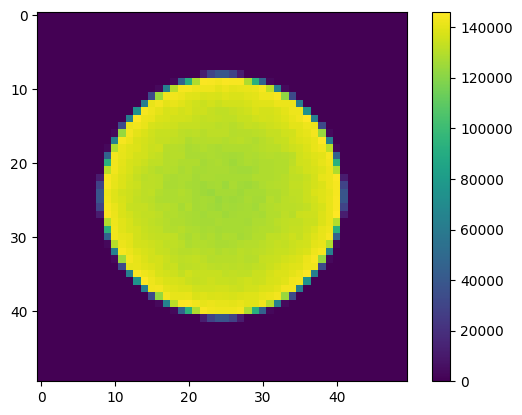

In [53]:
plt.figure()
img = plt.imshow(mesh_flux)
plt.colorbar(img)